In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-out-tenac.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

len(df)

10848

In [2]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

for attr in ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']:
    df[attr] = df[attr] * df['batter_multiplier']
    df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['batter_vibes'])
for attr in ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']:
    df[attr] = df[attr] * df['pitcher_multiplier']
    df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['pitcher_vibes'])

if "defender_vibes" in df:
    for attr in ["defense_avg_anticapitalism", "defense_avg_chasiness", "defense_avg_omniscience", "defense_avg_tenaciousness", "defense_avg_watchfulness"]:
        df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['defender_vibes'])
df['omni_tenac'] = df['defense_avg_omniscience_with_vibe'] * df['defense_avg_tenaciousness_with_vibe']


df['roll_minus_knowns'] = df['roll'] - 0.1 * df['batter_thwackability_with_vibe'] + 0.08 * df['pitcher_unthwackability_with_vibe']

/tmp/ipykernel_19422/3024795794.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['pitcher_vibes'])
/tmp/ipykernel_19422/3024795794.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['pitcher_vibes'])
/tmp/ipykernel_19422/3024795794.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

In [3]:
dfc = df
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
 dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
 dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
 dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
 dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc = dfc[dfc['roll'] < 0.7]
# dfc = dfc[dfc['roll'] > 0.2]
dfc = dfc[(dfc['pitcher_multiplier'] == 1) & (dfc['batter_multiplier'] == 1)]
# dfc = dfc[(dfc['pitcher_vibes'].abs() < 0.2) & (dfc['batter_vibes'].abs() < 0.2)]
# for limit_attr in ['batter_patheticism', 'batter_thwackability', 'batter_divinity', 'batter_musclitude', 'pitcher_ruthlessness']:
#     dfc = dfc[(dfc[limit_attr] > 0.1) & (dfc[limit_attr] < 0.9)]
# dfc = dfc[dfc['batter_thwackability'] + dfc['batter_musclitude'] + dfc['batter_divinity'] > dfc['batter_patheticism']]

# dfc = dfc[(dfc['fielder_roll'] < 0.025) | (dfc['fielder_roll'] > 0.975)]

len(dfc)

6515

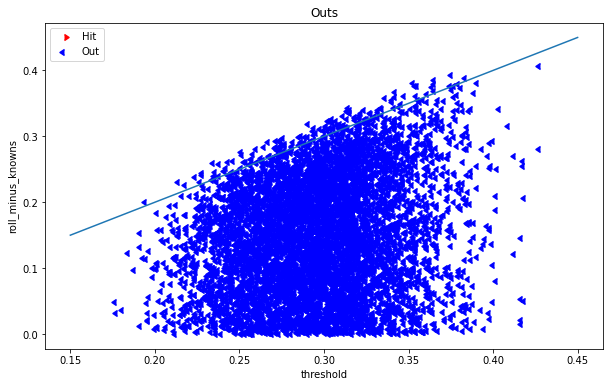

In [4]:
dfc['threshold'] = (0.28 - (
 -0.1 * dfc['batter_thwackability_with_vibe']
 +0.08 * dfc['pitcher_unthwackability_with_vibe']
 # +0.06 * dfc['defense_avg_omniscience_with_vibe']
))


x_val = "threshold"
# x_val = "svc_best"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Hit", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Out", marker=CARETLEFTBASE)
ax.set_xlabel(x_val)
ax.set_ylabel('roll_minus_knowns')
ax.set_title("Outs")
# ax.set_xlim(0.484, 0.499)

ax.plot((0.15, 0.45), (0.15, 0.45))

ax.legend()

,offset,event_type,home_score,away_score,top_of_inning,inning,pitcher_multiplier,batter_multiplier,baserunner_count,event_type,roll,threshold,batter_vibes,pitcher_vibes,pitcher_ruthlessness,batter_musclitude,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count,fielder_roll,ballpark_ominousness
9787,0.027973,BaseHit,0.0,2.0,False,3,1.0,1.0,[],BaseHit,0.319061,0.291087,-0.663007,-0.083227,0.831780,0.703479,Mira Lemma,Magi Ruiz,NaN,NaN,MAINTENANCE_MODE,NaN,47,45cdeeb0-48b5-48f6-9add-c8b2a69c1baf,104,0.556283,0.439184
4515,0.027637,BaseHit,1.0,3.0,True,6,1.0,1.0,[],BaseHit,0.342717,0.315080,-0.104404,-0.377365,0.959690,0.493887,Zion Aliciakeyes,Sosa Hayes,SWIM_BLADDER,NaN,FIREPROOF;SEALANT;AMBUSH,NaN,86,0114739e-8e98-4e4f-b387-52ad0a60c9fa,191,0.932112,0.471649
2454,0.027190,BaseHit,1.0,5.0,True,8,1.0,1.0,[],BaseHit,0.380452,0.353262,-0.301601,0.044198,0.928761,0.650666,Eduardo Woodman,Jolene Willowtree,NaN,NaN,AFFINITY_FOR_CROWS,MAINTENANCE_MODE,19,59e83fde-7fc2-4b8c-a77a-aa0a32ae9101,267,0.466739,0.439184
1443,0.024737,BaseHit,5.0,3.0,True,8,1.0,1.0,[],BaseHit,0.367210,0.342474,-0.099784,0.769264,0.691026,0.797885,Cannonball Sports,Lars Taylor,NaN,SWIM_BLADDER,LIFE_OF_PARTY;ELECTRIC,BASE_INSTINCTS,13,475a6c72-bb27-437d-9779-aacd0be2acbe,310,0.503333,0.513337
1710,0.024037,BaseHit,2.0,0.0,False,4,1.0,1.0,['cbd19e6f-3d08-4734-b23f-585330028665'],BaseHit,0.275747,0.251711,0.516450,-0.949973,1.093947,0.119170,Alexander Horne,Zoey Kirchner,NaN,NaN,LOVE,MAINTENANCE_MODE,15,e4bb76f3-416c-40c0-853e-3ae28451b461,145,0.496677,0.495296
7061,0.024022,BaseHit,0.0,0.0,True,0,1.0,1.0,['9f218ed1-d793-437d-a1b9-79f88f69154d'],BaseHit,0.258900,0.234878,-0.573158,-0.091930,0.359045,0.511266,Malik Destiny,Doc Anice,ALTERNATE;FIRE_EATER,NaN,NaN,AFFINITY_FOR_CROWS,32,27100629-f8ad-4b81-8a5f-54a596486860,19,0.232511,0.512809
9258,0.023998,HR,0.0,2.0,False,3,1.0,1.0,[],HR,0.339868,0.315869,-0.626531,0.186076,0.885310,0.698159,Yusef Fenestrate,Mummy Melcon,NaN,NaN,NaN,FIREPROOF;SEALANT;AMBUSH,44,89c60e5b-0f84-4ac2-96fa-9e361a231042,110,0.949725,0.454527
9487,0.023928,BaseHit,7.0,0.0,False,3,1.0,1.0,['2f85d731-81ed-4a07-9e01-e93f1786a366'],BaseHit,0.338089,0.314161,-0.251731,0.777349,0.592667,0.082867,Kelvin Drumsolo,Lenny Marijuana,NaN,NaN,MAINTENANCE_MODE,NaN,45,65c112ec-35cb-4c38-8585-105faf61f062,178,0.587830,0.439184
10524,0.023308,BaseHit,0.0,3.0,False,1,1.0,1.0,[],BaseHit,0.290709,0.267400,0.086539,0.042795,1.108926,0.386584,Silvaire Semiquaver,Hiroto Wilcox,NaN,FRIEND_OF_CROWS,NaN,FIREPROOF;SEALANT;AMBUSH,103,ad34e28d-64c8-4b53-805e-fbd2b75da2c9,54,0.501882,0.454527
884,0.021734,BaseHit,4.0,1.0,True,8,1.0,1.0,"['ab36c776-b520-429b-a85f-bf633d7b081a', 'ad8d...",BaseHit,0.297824,0.276091,0.078766,-0.609125,1.341412,0.542132,Socks Maybe,Burke Gonzales,NaN,ALTERNATE,NaN,NaN,10,ab6334a0-f2d0-4514-bea1-164823f3295e,298,0.101018,0.492195


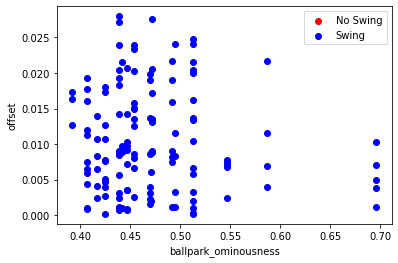

In [5]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_ominousness"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="No Swing")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Swing")
ax.set_xlabel(x_val)
ax.set_ylabel('offset')
ax.legend()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
table = outliers#[outliers['ballpark_ominousness'] > 0.6]
table[["offset", "event_type", "home_score", "away_score", "top_of_inning", "inning",
       "pitcher_multiplier", "batter_multiplier", "baserunner_count", "event_type",
       "roll", "threshold", "batter_vibes", "pitcher_vibes",
       "pitcher_ruthlessness", "batter_musclitude",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count",
       "fielder_roll", "ballpark_ominousness"]].sort_values('offset', ascending=False)
# len(table)

In [6]:
dfc.corr()['offset'].sort_values()

threshold                              -0.224798
batter_thwackability_with_vibe         -0.176881
batter_thwackability                   -0.172588
omni_tenac                             -0.064621
defense_avg_omniscience                -0.064407
defense_avg_omniscience_with_vibe      -0.062784
batter_musclitude_with_vibe            -0.062311
batter_musclitude                      -0.056285
defense_avg_watchfulness_with_vibe     -0.048070
defense_avg_watchfulness               -0.047669
defense_avg_tenaciousness              -0.044729
batter_overpowerment_with_vibe         -0.044412
defense_avg_tenaciousness_with_vibe    -0.043005
batter_overpowerment                   -0.039530
pitcher_continuation                   -0.037923
batter_buoyancy_with_vibe              -0.037551
defense_avg_chasiness                  -0.035735
batter_unthwackability_with_vibe       -0.034245
defense_avg_chasiness_with_vibe        -0.033133
pitcher_continuation_with_vibe         -0.033036
batter_vibes        

In [7]:
X = dfc[['roll_minus_knowns', 'passed',
 # 'batter_thwackability_with_vibe',
 # 'pitcher_unthwackability_with_vibe',
 # 'defense_avg_omniscience',
 # 'defense_avg_omniscience_with_vibe',
 # 'omni_tenac',
# 'ballpark_grandiosity',
#  'ballpark_fortification',
 'ballpark_obtuseness',
 'ballpark_ominousness',
 'ballpark_inconvenience',
 # 'ballpark_viscosity',
 # 'ballpark_forwardness',
 # 'ballpark_mysticism',
 'ballpark_elongation',
 # 'ballpark_filthiness',
         ]]
# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X['passed']
X = X.drop('passed', axis=1)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(intercept_scaling=100, dual=False, max_iter=100000, C=1000).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y,predictionsvm))
print(classification_report(y,predictionsvm))

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: True

In [ ]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

In [ ]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

In [ ]:
df.sort_values('pitcher_ruthlessness')[['pitcher_name', 'pitcher_ruthlessness', 'pitcher_multiplier']]

In [ ]:
dfc[dfc['pitcher_ruthlessness'] > 1.6]

In [ ]:
outliers = dfc[~dfc['passed'] & (dfc['roll'] < 0.1)]
outliers

In [ ]:
df[df['batter_thwackability'] + df['batter_musclitude'] + df['batter_divinity'] < df['batter_patheticism']]

In [ ]:
list(df.columns)